# KM Interactions in Mali
### by Jahnavi G

# Table of contents
<div class="alert alert-block alert-danger">NOTE: The content links don't work on github web (only on local machine). Happy scrolling!</div>

1. [Data Setup](#setup)
2. [Call Composition](#cc)
    1. [Key Observations](#cc_key_obs)

## Data Setup <a name="setup"></a>

In [ ]:
#packages----
#data connection
library(bigrquery)
library(dbplyr)
library(dplyr)
library(lubridate) #for date transformations
library(ggplot2)
library(viridis) #ggplot colour
library(ggthemes)

#Raw data extraction for Mali----
bq_auth(path = "jsonkey/viamo-datakind-19b12e3872f5.json")
con <- DBI::dbConnect(
  bigrquery::bigquery(),
  project = "viamo-datakind", 
  dataset = "datadive", 
  bigint = "integer64",
  billing = "viamo-datakind"
)
con
dbListTables(con)

raw_data <- tbl(con, "321_sessions_1122")
data_mali <- raw_data %>% 
  select(organization_country, 
         call_id, 
         call_date,
         block_interaction_id, 
         duration_listened_seconds, 
         block_audio_percent_listened, 
         block_title, block_theme, 
         block_topic, km_block_reached, 
         km_block_listened,
         km_block_reached,
         listener) %>%
  #extracting day from date - to check difference btw weekdays/weekends
  # mutate(call_day = format(call_date, format = "%d")) %>% 
  #mutate(call_day = wday(call_date, week_start = 1)) %>% 
  filter(organization_country == "Mali")

## Call Composition <a name="cc"></a>
### Proportion of KMs:other blocks per call

`summarise()` has grouped output by "n_km_int". You can override using the `.groups` argument.
Warning message:
"Removed 5620 rows containing missing values (`position_stack()`)."
Warning message:
"Removed 41 rows containing missing values (`geom_col()`)."


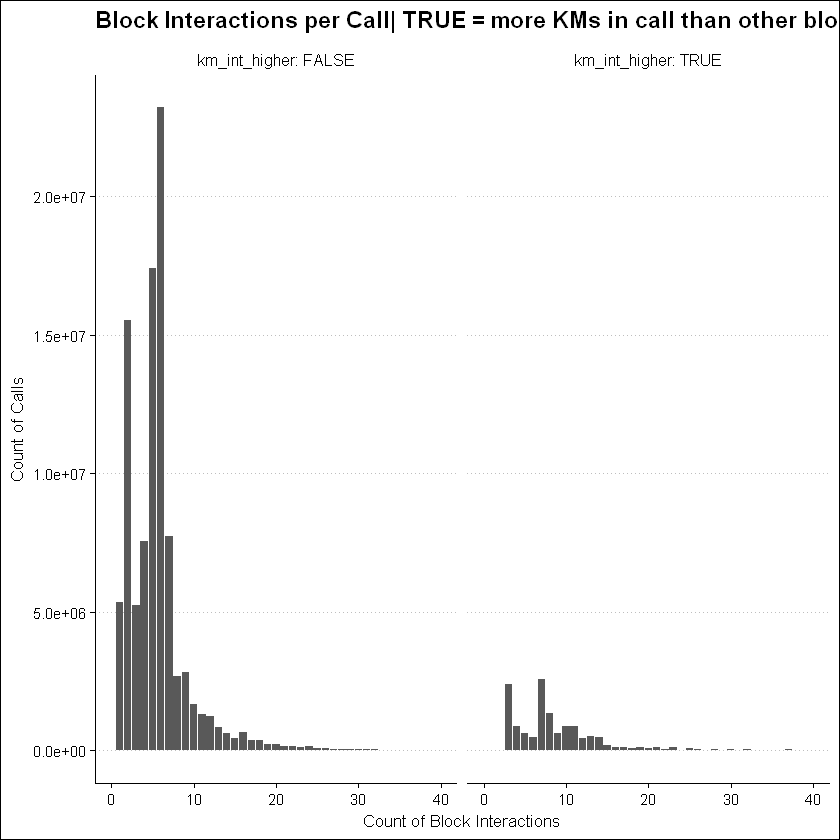

In [2]:
#Q15: Within an individual call (call_id), what is the distribution 
# of the number of KMs that occur within a single call?

#KM:non-KM interactions among callers
data <-  data_mali %>% 
  mutate(is_km = not(is.null(km_block_reached))) %>% #adding Boolean field for km/non-km
  group_by(call_id) %>% 
  summarise(n_km_int = n_distinct(block_interaction_id[is_km]), #km blocks
            n_nonkm_int = n_distinct(block_interaction_id[not(is_km)])) %>%  #non-km blocks
  ungroup() %>% 
  group_by(n_km_int, n_nonkm_int) %>% 
  summarise(n_call = n_distinct(call_id)) %>% collect

data <- as.data.frame(data)

#assigning the right data class
data$n_km_int <- as.numeric(data$n_km_int)
data$n_nonkm_int <- as.numeric(data$n_nonkm_int)
data$n_call <- as.numeric(data$n_call)

#adding proportions
data$total_blk_int <- data$n_km_int + data$n_nonkm_int
data$p_km_int <- round(data$n_km_int*100/data$total_blk_int, 0)
data$p_nonkm_int <- 100-data$p_km_int
data$km_int_higher <- data$p_km_int > data$p_nonkm_int #where propn of KMs is > non-KM blocks

###vizualization----
#barplot version of hist since data is too huge for the expanded version
plot_blk_int <- ggplot(data, aes(x=total_blk_int, y=n_call)) +
  geom_col() +
  scale_x_continuous(limits = c(0, 40), name = "Count of Block Interactions") +
  scale_y_continuous(name = "Count of Calls") +
  ggtitle("Block Interactions per Call| TRUE = more KMs in call than other blocks") +
  theme_clean() +
  facet_wrap(~km_int_higher, nrow=1, 
             labeller = label_both)

plot_blk_int  

#### Key Observations <a name="cc_key_obs"></a>
- Most calls have a greater proportion of other blocks than KMs. This is expected since there are far greater number of blocks that a user may interact with before arriving at a KM. 
- More interestingly, **24% of the calls have 0 Key Messages.**
- **Conversely, 12% of the calls have a greater proportion of KMs than other blocks.** <br>
It will be interesting to dig further into the block content of these 2 sets of calls - 
    - **What sets these calls apart?**
    - **Are the calls with a higher proportion of KMs consolidated around a particular date?**
    - **How can we increase the frequency of calls with higher proportion of KMs?**